## Dependencies

In [1]:
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [2]:
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
REPLICAS = strategy.num_replicas_in_sync
print("REPLICAS: ", REPLICAS)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Model parameters

In [4]:
config = {
  "HEIGHT": 384,
  "WIDTH": 384,
  "CHANNELS": 3,
  "BATCH_SIZE": 32,
  "EPOCHS": 12,
  "LEARNING_RATE": 1e-3,
  "ES_PATIENCE": 5,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 11,
  "BASE_MODEL": 'EfficientNetB4',
  "BASE_MODEL_WEIGHTS": 'imagenet',
  "DATASET_PATH": 'melanoma-384x384'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'HEIGHT': 384,
 'WIDTH': 384,
 'CHANNELS': 3,
 'BATCH_SIZE': 32,
 'EPOCHS': 12,
 'LEARNING_RATE': 0.001,
 'ES_PATIENCE': 5,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 11,
 'BASE_MODEL': 'EfficientNetB4',
 'BASE_MODEL_WEIGHTS': 'imagenet',
 'DATASET_PATH': 'melanoma-384x384'}

# Load data

In [5]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = KaggleDatasets().get_gcs_path(config['DATASET_PATH'])
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [6]:
def data_augment(image):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotation = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    if p_pixel >= .2: # Pixel-level transforms
      if p_pixel >= .75:
        image = data_augment_saturation(image)
      elif p_pixel >= .5:
        image = data_augment_contrast(image)
      else:
        image = data_augment_brightness(image)

    if p_rotation >= .2: # Rotation
      image = data_augment_rotation(image)

    if p_spatial2 >= .2: 
      if p_spatial2 >= .6: # Shift
        image = data_augment_shift(image)
      else: # Shear
        image = data_augment_shear(image)
        
    if p_spatial >= .2:
      if p_spatial >= .6: # Flips
        image = data_augment_spatial(image)
      else: # Rotate
        image = data_augment_rotate(image)

    if p_crop >= .2: # Crops
      image = data_augment_crop(image)
    
    if p_cutout >= .2: # Cutout
      image = data_augment_cutout(image)
    
    return image

def data_augment_tta(image):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotation = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    if p_pixel >= .2: # Pixel-level transforms
      if p_pixel >= .75:
        image = data_augment_saturation(image)
      elif p_pixel >= .5:
        image = data_augment_contrast(image)
      else:
        image = data_augment_brightness(image)

    if p_rotation >= .2: # Rotation
      image = data_augment_rotation(image)

    if p_spatial2 >= .2: 
      if p_spatial2 >= .6: # Shift
        image = data_augment_shift(image)
      else: # Shear
        image = data_augment_shear(image)
        
    if p_spatial >= .2:
      if p_spatial >= .6: # Flips
        image = data_augment_spatial(image)
      else: # Rotate
        image = data_augment_rotate(image)

    if p_crop >= .2: # Crops
      image = data_augment_crop(image)
    
    
    return image


def data_augment_rotation(image, max_angle=45.):
    image = transform_rotation(image, config['HEIGHT'], max_angle)
    return image

def data_augment_shift(image, h_shift=50., w_shift=50.):
    image = transform_shift(image, config['HEIGHT'], h_shift, w_shift)
    return image

def data_augment_shear(image, shear=25.):
    image = transform_shear(image, config['HEIGHT'], shear)
    return image

def data_augment_saturation(image, lower=.8, upper=1.2):
    image = tf.image.random_saturation(image, lower, upper)
    return image

def data_augment_contrast(image, lower=.8, upper=1.2):
    image = tf.image.random_contrast(image, lower, upper)
    return image

def data_augment_brightness(image, max_delta=.1):
    image = tf.image.random_brightness(image, max_delta)
    return image

def data_augment_spatial(image):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)    
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_crop > .5:
        if p_crop > .9:
            image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop > .7:
            image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        else:
            image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
    else:
        if p_crop > .4:
            image = tf.image.central_crop(image, central_fraction=.5)
        elif p_crop > .2:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    
    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_cutout(image, min_mask_size=(int(config['HEIGHT'] * .05), int(config['HEIGHT'] * .05)), 
                        max_mask_size=(int(config['HEIGHT'] * .25), int(config['HEIGHT'] * .25))):
    p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_cutout > .9: # 3 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=3)
    elif p_cutout > .75: # 2 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=2)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

## Auxiliary functions

In [7]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0
 
def prepare_image(img, augment=None, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = augment(img)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def get_dataset(files, augment=None, shuffle=False, repeat=False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

## Learning rate scheduler

Learning rate schedule: 0 to 0.000998 to 1.49e-06


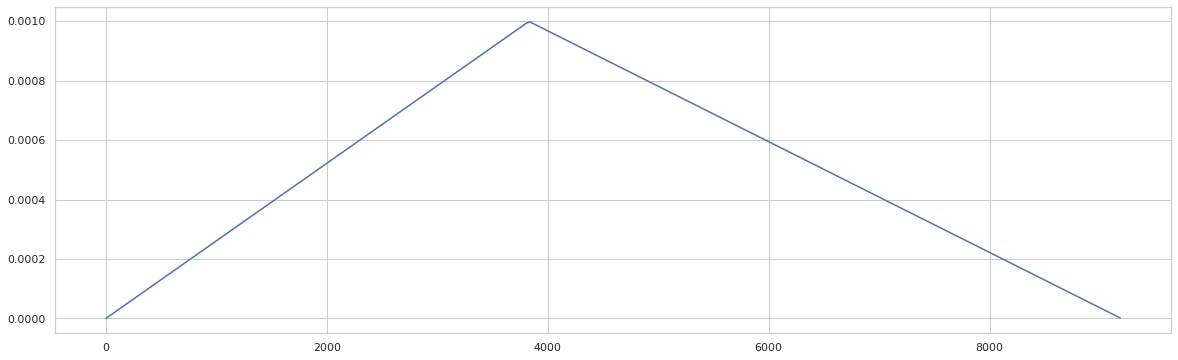

In [8]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24519 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
hold_max_steps = 0

rng = [i for i in range(0, total_steps, 32)]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                               warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                               lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [9]:
# Initial bias
pos = len(train[train['target'] == 1])
neg = len(train[train['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(train)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
584
32542
[-4.02038586]
Class weight
{0: 0.5089730194825148, 1: 28.36130136986301}


In [10]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB6(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [11]:
skf = KFold(n_splits=config['N_FOLDS'], shuffle=True, random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = []; history_list = []; oof_pred_light = []
preds = np.zeros((count_data_items(TEST_FILENAMES), 1))
preds_light = np.zeros((count_data_items(TEST_FILENAMES), 1))

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    print('\nFOLD: %d' % (fold+1))
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    TRAINING_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxT])
    np.random.shuffle(TRAINING_FILENAMES)
    files_valid = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxV])
    TEST_FILENAMES = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))

    ct_train = count_data_items(TRAINING_FILENAMES)
    ct_valid = count_data_items(files_valid)
    ct_test = count_data_items(TEST_FILENAMES)
    STEPS_VALID = config['TTA_STEPS'] * ct_valid/config['BATCH_SIZE']/4/REPLICAS
    STEPS_TEST = config['TTA_STEPS'] * ct_test/config['BATCH_SIZE']/4/REPLICAS

    steps_per_epoch = ct_train // config['BATCH_SIZE']
    total_steps = config['EPOCHS'] * steps_per_epoch
    warmup_steps = steps_per_epoch * 5
    
    # BUILD MODEL
    K.clear_session()
    model_path = f'model_fold_{fold}.h5'
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
        optimizer = tfa.optimizers.RectifiedAdam(lr=config['LEARNING_RATE'],
                                                 total_steps=int(total_steps),
                                                 warmup_proportion=(warmup_steps / total_steps),
                                                 min_lr=1e-6)
        model.compile(optimizer=optimizer, metrics=['AUC'], 
                      loss=losses.BinaryCrossentropy(label_smoothing=0.05))
        
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)
   
    # TRAIN
    print('Training...')
    history = model.fit(get_dataset(TRAINING_FILENAMES, augment=data_augment, shuffle=True, repeat=True,
                                    dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']), 
                        validation_data=get_dataset(files_valid, augment=None, shuffle=False,
                                                    repeat=False, dim=config['HEIGHT']), 
                        steps_per_epoch=steps_per_epoch//REPLICAS,
                        epochs=config['EPOCHS'], 
                        callbacks=[checkpoint], 
                        verbose=2).history
    
    history_list.append(history)

    # save last epoch weights
    model.save_weights('last_' + model_path)
    
    print('Loading best model...')
    model.load_weights(model_path)
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid, labeled=False, return_image_names=False, augment=data_augment, repeat=True, 
                           shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_valid, steps=STEPS_VALID, verbose=2)[:config['TTA_STEPS']*ct_valid,] 
    oof_pred.append(np.mean(pred.reshape((ct_valid, config['TTA_STEPS']), order='F'),axis=1) )      
    
    # PREDICT OOF USING TTA (light)
    print('Predicting OOF with TTA (light)...')
    ds_valid = get_dataset(files_valid, labeled=False, return_image_names=False, augment=data_augment_tta, repeat=True, 
                           shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_valid, steps=STEPS_VALID, verbose=2)[:config['TTA_STEPS']*ct_valid,] 
    oof_pred_light.append(np.mean(pred.reshape((ct_valid, config['TTA_STEPS']), order='F'),axis=1) )                 
    
    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=None, repeat=False, dim=config['HEIGHT'],
            labeled=True, return_image_names=True)
    oof_tar.append(np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=None, repeat=False, dim=config['HEIGHT'],
                labeled=False, return_image_names=True)
    oof_names.append(np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(TEST_FILENAMES,labeled=False,return_image_names=False,augment=data_augment,
            repeat=True,shuffle=False,dim=config['HEIGHT'],batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_test,steps=STEPS_TEST,verbose=2)[:config['TTA_STEPS']*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test, config['TTA_STEPS']), order='F'),axis=1) * (1/config['N_USED_FOLDS'])
    
    # PREDICT TEST USING TTA (light)
    print('Predicting Test with TTA...')
    ds_test = get_dataset(TEST_FILENAMES,labeled=False,return_image_names=False,augment=data_augment_tta,
            repeat=True,shuffle=False,dim=config['HEIGHT'],batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_test,steps=STEPS_TEST,verbose=2)[:config['TTA_STEPS']*ct_test,] 
    preds_light[:,0] += np.mean(pred.reshape((ct_test, config['TTA_STEPS']), order='F'),axis=1) * (1/config['N_USED_FOLDS'])
    
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1], oof_pred[-1])
    auc_light = roc_auc_score(oof_tar[-1], oof_pred_light[-1])
    oof_val.append(np.max(history['val_auc'] ))
    print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f with TTA (light) = %.3f' % 
          (fold+1, oof_val[-1], auc, auc_light))


FOLD: 1
165527552/165527152 [==============================] - 6s 0us/step
Training...
Epoch 1/12
102/102 - 115s - auc: 0.5441 - loss: 0.1849 - val_auc: 0.5290 - val_loss: 0.1849
Epoch 2/12
102/102 - 87s - auc: 0.6323 - loss: 0.1820 - val_auc: 0.6185 - val_loss: 0.1833
Epoch 3/12
102/102 - 87s - auc: 0.7445 - loss: 0.1736 - val_auc: 0.7813 - val_loss: 0.1748
Epoch 4/12
102/102 - 86s - auc: 0.8072 - loss: 0.1688 - val_auc: 0.8460 - val_loss: 0.1702
Epoch 5/12
102/102 - 87s - auc: 0.8533 - loss: 0.1680 - val_auc: 0.8678 - val_loss: 0.1658
Epoch 6/12
102/102 - 86s - auc: 0.8644 - loss: 0.1655 - val_auc: 0.8689 - val_loss: 0.1655
Epoch 7/12
102/102 - 86s - auc: 0.8826 - loss: 0.1623 - val_auc: 0.8764 - val_loss: 0.1644
Epoch 8/12
102/102 - 85s - auc: 0.8845 - loss: 0.1615 - val_auc: 0.8569 - val_loss: 0.1642
Epoch 9/12
102/102 - 81s - auc: 0.8828 - loss: 0.1644 - val_auc: 0.8863 - val_loss: 0.1645
Epoch 10/12
102/102 - 81s - auc: 0.8998 - loss: 0.1609 - val_auc: 0.8941 - val_loss: 0.1642


## Model loss graph

Fold: 1


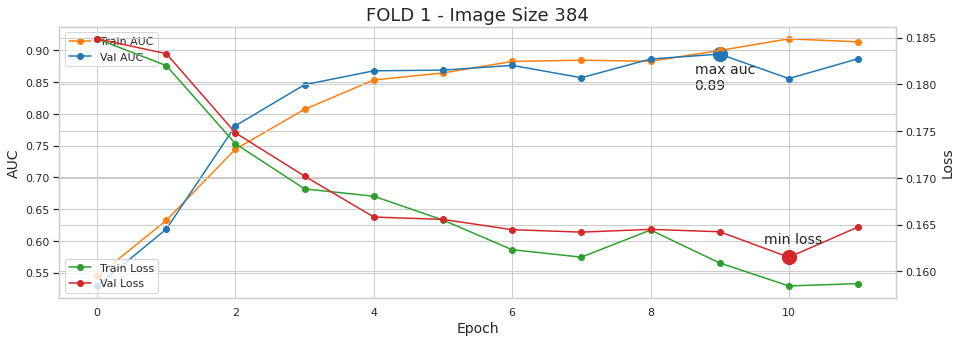

Fold: 2


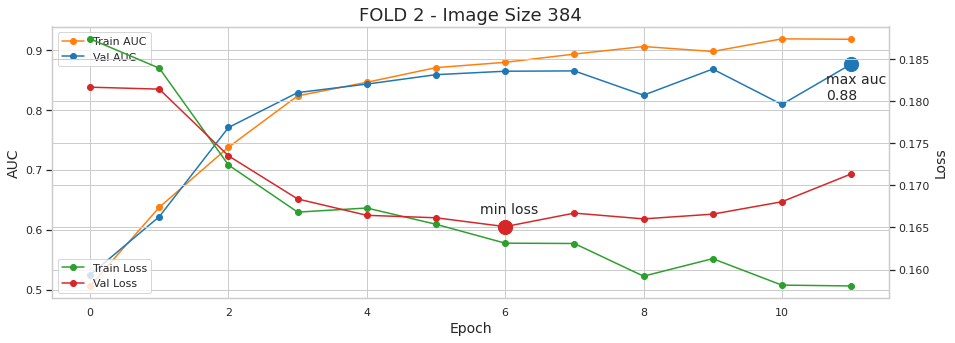

Fold: 3


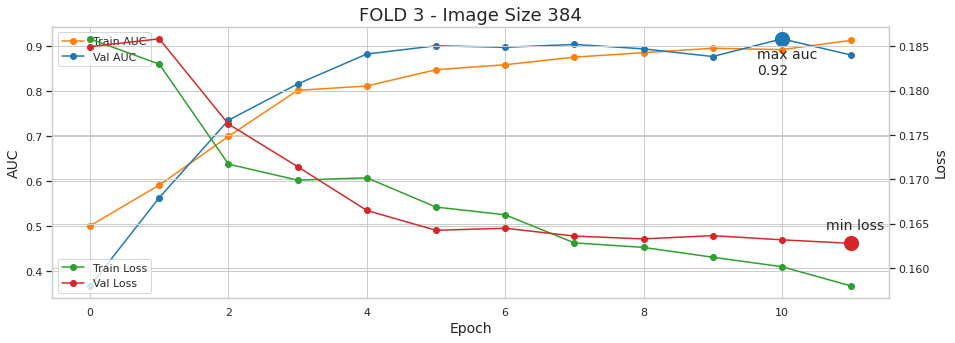

Fold: 4


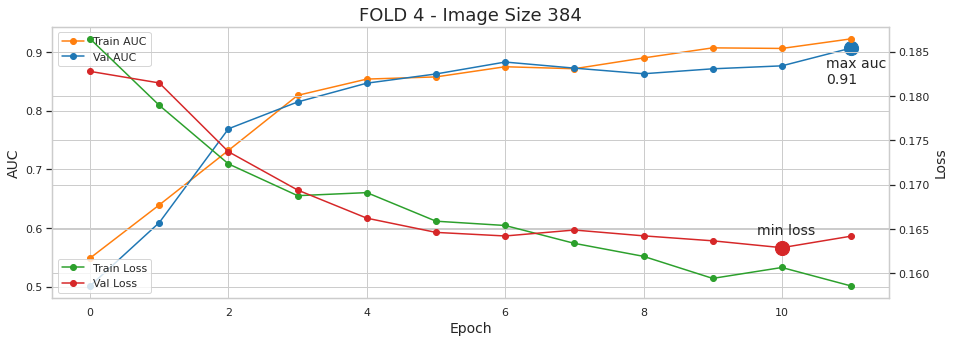

Fold: 5


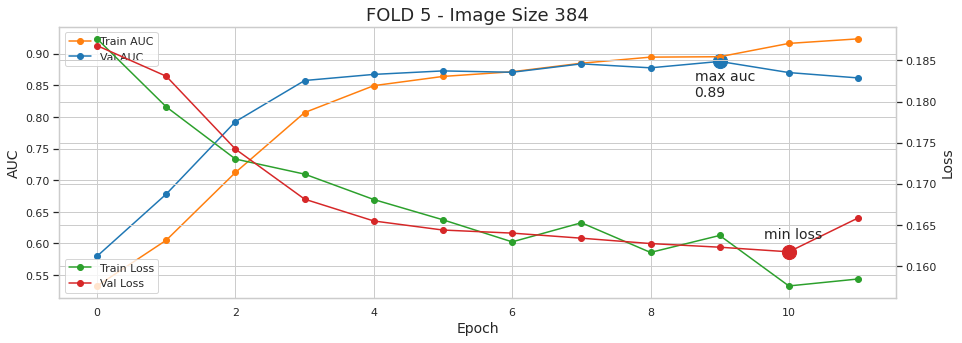

In [12]:
for n_fold, history in enumerate(history_list):
    print(f'Fold: {n_fold + 1}')
    ##### Plot metrics #####
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(config['EPOCHS']), history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    plt.plot(np.arange(config['EPOCHS']), history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
    x = np.argmax(history['val_auc'])
    y = np.max(history['val_auc'])
    xdist = plt.xlim()[1] - plt.xlim()[0]
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4')
    plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC',size=14)
    plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(config['EPOCHS']), history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(config['EPOCHS']), history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin(history['val_loss'])
    y = np.min(history['val_loss'])
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728')
    plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('FOLD %i - Image Size %i' % (n_fold+1, config['HEIGHT']), size=18)
    plt.legend(loc=3)
    plt.show()

## Model loss graph aggregated

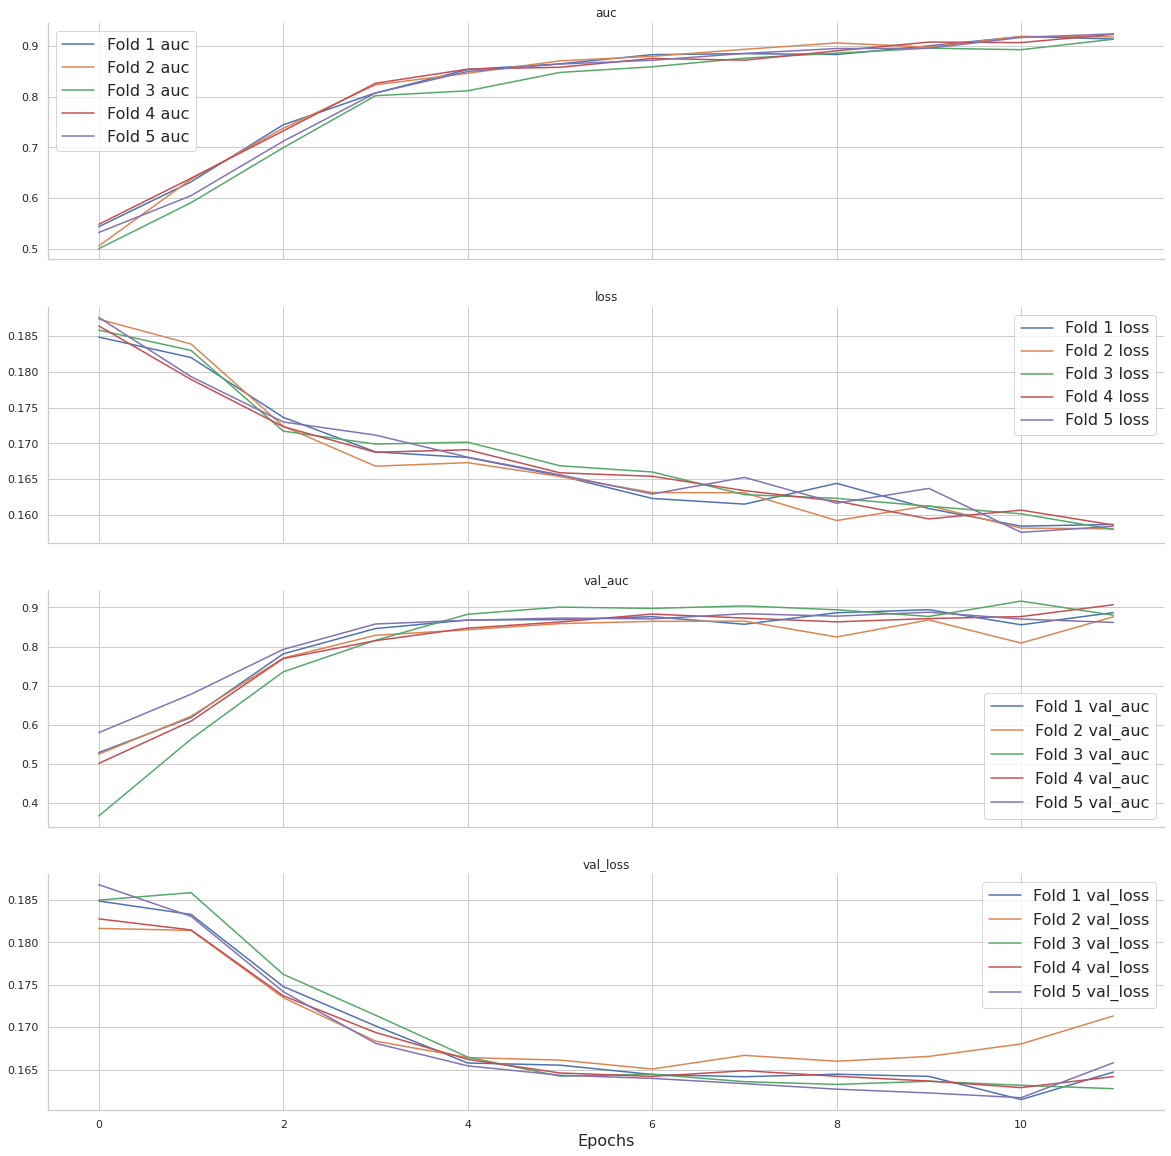

In [13]:
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [14]:
# COMPUTE OVERALL OOF AUC (light)
oof = np.concatenate(oof_pred_light)
true = np.concatenate(oof_tar)
names = np.concatenate(oof_names)
folds = np.concatenate(oof_folds)
auc = roc_auc_score(true, oof)
print('Overall OOF AUC with TTA (light) = %.3f' % auc)


# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred)
true = np.concatenate(oof_tar)
names = np.concatenate(oof_names)
folds = np.concatenate(oof_folds)
auc = roc_auc_score(true, oof)
print('Overall OOF AUC with TTA = %.3f' % auc)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(image_name=names, target=true, pred=oof, fold=folds))
df_oof.to_csv('oof.csv', index=False)
df_oof.head()

Overall OOF AUC with TTA (light) = 0.893
Overall OOF AUC with TTA = 0.896


,image_name,target,pred,fold
0,ISIC_2637011,0,0.038729,0
1,ISIC_0076262,0,0.029205,0
2,ISIC_0074268,0,0.022657,0
3,ISIC_0015719,0,0.025423,0
4,ISIC_0082543,0,0.025959,0


# Visualize test predictions

Test predictions 11|10971
Top 10 samples


,image_name,target,target_light
9905,ISIC_0052060,0.027950,0.029933
1443,ISIC_0052349,0.024514,0.024354
3120,ISIC_0058510,0.024398,0.024755
4870,ISIC_0073313,0.023273,0.023452
5494,ISIC_0073502,0.025857,0.025857
4537,ISIC_0074618,0.033396,0.032899
4819,ISIC_0076801,0.032348,0.033554
7203,ISIC_0077586,0.033601,0.036706
10897,ISIC_0082004,0.029547,0.030878
5093,ISIC_0082785,0.032456,0.032612


Top 10 positive samples


,image_name,target,target_light
2280,ISIC_0112420,0.548406,0.548828
10640,ISIC_1364884,0.765436,0.776785
1408,ISIC_1593714,0.733489,0.727703
6029,ISIC_2170268,0.528262,0.538370
7042,ISIC_2560699,0.649137,0.674930
468,ISIC_2839742,0.688378,0.698709
6013,ISIC_6814727,0.528287,0.506692
1053,ISIC_9114248,0.723316,0.699217
815,ISIC_9478088,0.652661,0.633859
3492,ISIC_9495534,0.520414,0.576826


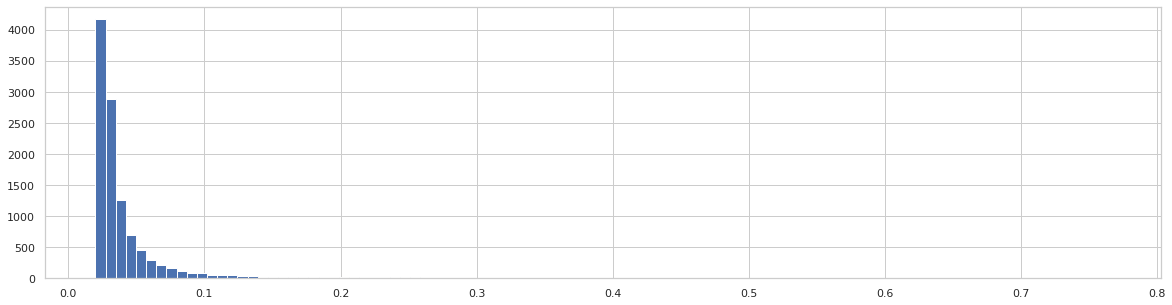

In [15]:
ds = get_dataset(TEST_FILENAMES, augment=False, repeat=False, dim=config['HEIGHT'],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())])

submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0], target_light=preds_light[:,0]))
submission = submission.sort_values('image_name')

print(f"Test predictions {len(submission[submission['target'] > .5])}|{len(submission[submission['target'] <= .5])}")

print('Top 10 samples')
display(submission.head(10))

print('Top 10 positive samples')
display(submission.query('target > .5').head(10))

fig = plt.subplots(figsize=(20, 5))
plt.hist(submission['target'], bins=100)
plt.show()

# Test set predictions

In [16]:
submission['target_blend'] = (submission['target'] * .5) +  (submission['target_light'] * .5)
display(submission.head(10))
display(submission.describe().T)

submission[['image_name', 'target']].to_csv('submission.csv', index=False)

### LAST ###
submission_light = submission[['image_name', 'target_light']]
submission_light.columns = ['image_name', 'target']
submission_light.to_csv('submission_light.csv', index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv('submission_blend.csv', index=False)

,image_name,target,target_light,target_blend
9905,ISIC_0052060,0.027950,0.029933,0.028941
1443,ISIC_0052349,0.024514,0.024354,0.024434
3120,ISIC_0058510,0.024398,0.024755,0.024577
4870,ISIC_0073313,0.023273,0.023452,0.023363
5494,ISIC_0073502,0.025857,0.025857,0.025857
4537,ISIC_0074618,0.033396,0.032899,0.033148
4819,ISIC_0076801,0.032348,0.033554,0.032951
7203,ISIC_0077586,0.033601,0.036706,0.035154
10897,ISIC_0082004,0.029547,0.030878,0.030213
5093,ISIC_0082785,0.032456,0.032612,0.032534


,count,mean,std,min,25%,50%,75%,max
target,10982.0,0.043569,0.045465,0.019903,0.025652,0.029850,0.041855,0.765436
target_light,10982.0,0.044401,0.045942,0.019738,0.026275,0.030769,0.042699,0.776785
target_blend,10982.0,0.043985,0.045638,0.019972,0.025968,0.030308,0.042307,0.771110
